In [25]:
import pandas as pd

data = pd.read_csv('data.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500


In [26]:
df=data.reset_index()['Close']
df.head()

0    14.620667
1    14.006000
2    14.085333
3    14.063333
4    14.041333
Name: Close, dtype: float64

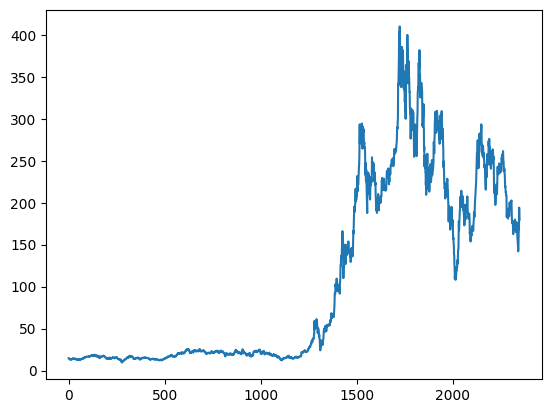

In [27]:
import matplotlib.pyplot as plt
plt.plot(df)

In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
# df=scaler.fit_transform(np.array(df)) # will give error so we have to reshape data
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [29]:
df

array([[0.01259433],
       [0.01105916],
       [0.0112573 ],
       ...,
       [0.46072849],
       [0.43382984],
       [0.42561291]])

In [30]:
##splitting dataset into train and test split
training_size=int(len(df)*0.75)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [31]:
training_size,test_size


(1761, 587)

In [32]:
train_data

array([[0.01259433],
       [0.01105916],
       [0.0112573 ],
       ...,
       [0.8868026 ],
       [0.88224873],
       [0.88035056]])

In [33]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [35]:
print(X_train.shape), print(y_train.shape)


(1710, 50)
(1710,)


(None, None)

In [36]:
print(X_test.shape), print(ytest.shape)


(536, 50)
(536,)


(None, None)

In [37]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [38]:
### Create the Stacked LSTM model
from keras.models import Sequential # type: ignore
from keras.layers import Dense # type: ignore
from keras.layers import LSTM # type: ignore

In [39]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\Projects\Stock-Price-Predictor-LSTM\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=3,batch_size=64,verbose=1)

Epoch 1/3


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0210 - val_loss: 0.0053
Epoch 2/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 3/3
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 9.5063e-04 - val_loss: 0.0059


In [42]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [43]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [44]:

### Calculate RMSE performance metrics
import math # type: ignore
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

112.48767629615955

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

246.84428687369777

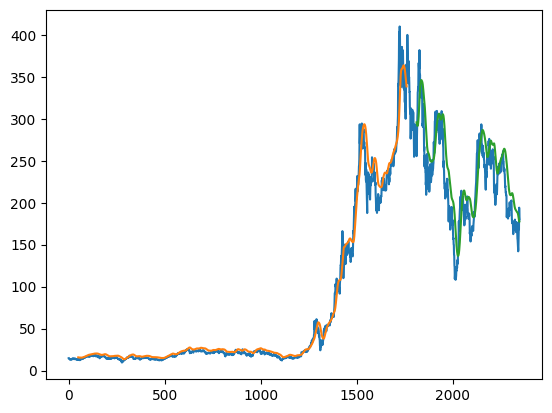

In [46]:
### Plotting 
# shift train predictions for plotting
look_back=50
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [51]:
model.save("lstm.keras")

model1 = keras.models.load('lstm.keras')
print(model1)

In [52]:
import keras
model1 = keras.saving.load_model("lstm.keras")
print(model1)

<Sequential name=sequential_1, built=True>


d:\Projects\Stock-Price-Predictor-LSTM\venv\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
